Shape: (6362620, 11)

Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

Dtypes:
 float64    5
int64      3
object     3
Name: count, dtype: int64

Target distribution:
 isFraud
0    6354407
1       8213
Name: count, dtype: int64


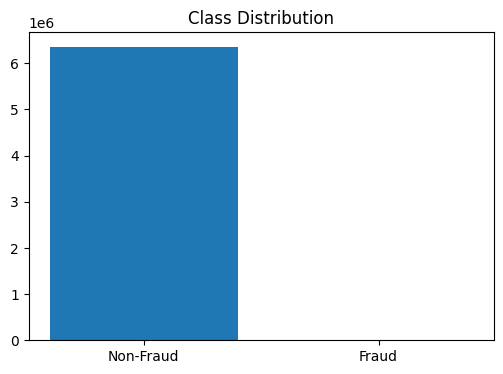

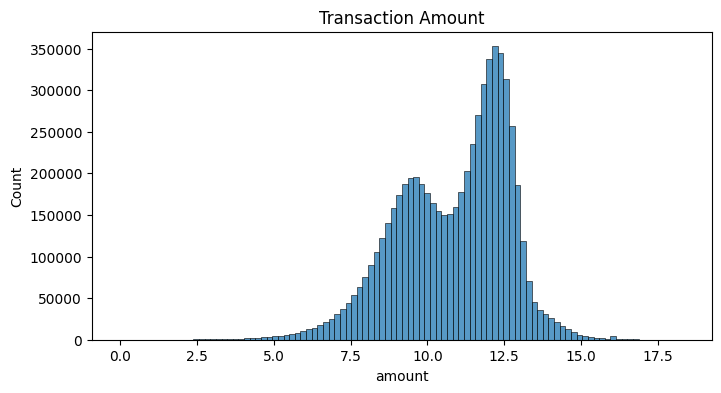

Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.999484	valid_0's binary_logloss: 0.231625
[200]	valid_0's auc: 0.999564	valid_0's binary_logloss: 0.0975645
Early stopping, best iteration is:
[170]	valid_0's auc: 0.999575	valid_0's binary_logloss: 0.123583

Top 20 Important Features:
          feature    importance
3   oldbalanceOrg  9.368023e+07
4  newbalanceOrig  9.152436e+07
2          amount  4.833214e+07
1            type  3.907162e+07
0            step  9.032379e+06
6  newbalanceDest  7.322698e+06
5  oldbalanceDest  3.366628e+06


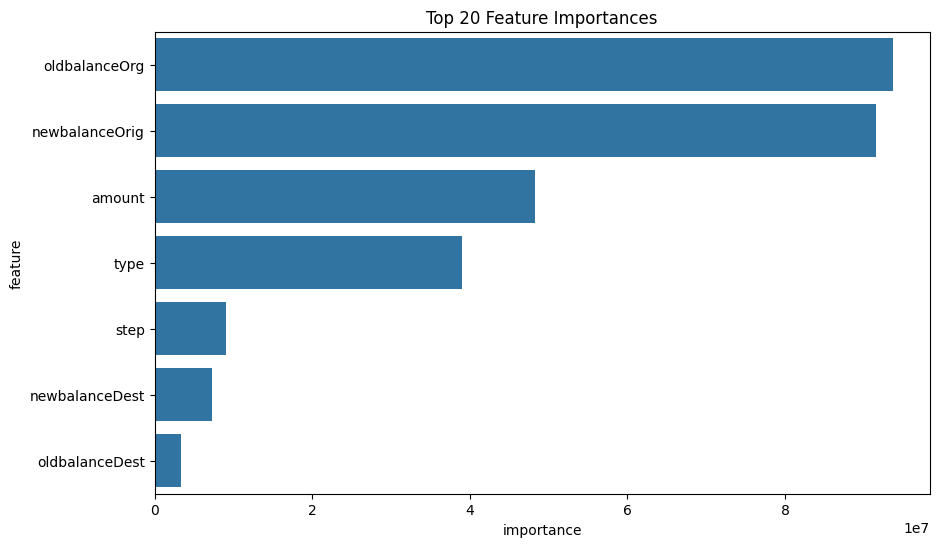


Selected 7 features out of 7 total.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.990103

Best F1: 0.8669 at threshold=0.88

ROC-AUC: 0.9995751048487777
AUPRC: 0.9206749960884477

Confusion Matrix:
 [[1270774     107]
 [    304    1339]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.9999    0.9998   1270881
           1     0.9260    0.8150    0.8669      1643

    accuracy                         0.9997   1272524
   macro avg     0.9629    0.9074    0.9334   1272524
weighted avg     0.9997    0.9997    0.9997   1272524

Precision at 1000: 1.0000


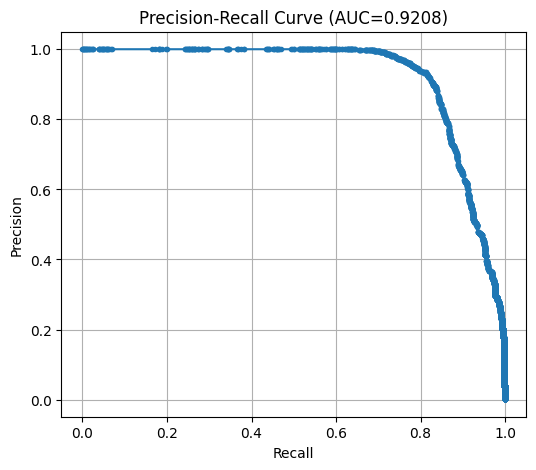

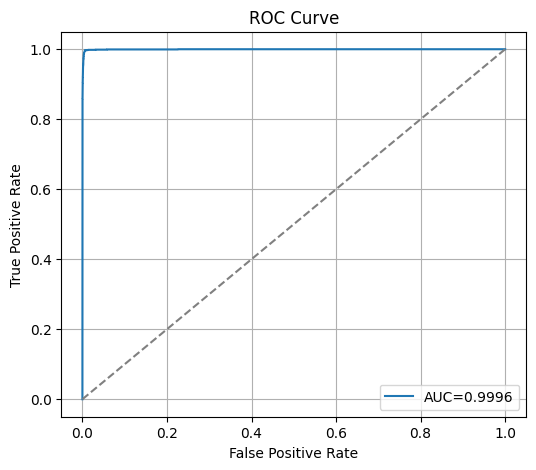

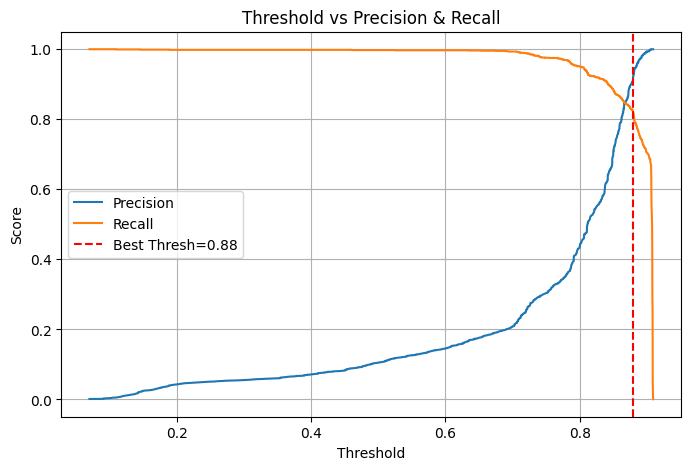

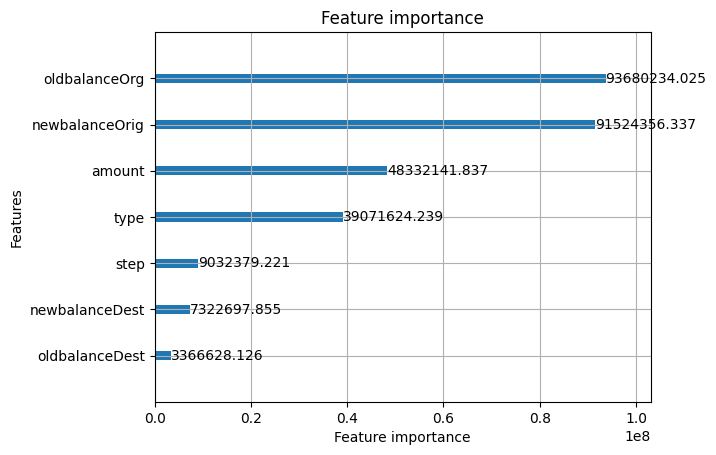

In [24]:
#required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, f1_score, roc_auc_score, average_precision_score, roc_curve

# Load the Dataset
df = pd.read_csv("Fraud.csv")

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nDtypes:\n", df.dtypes.value_counts())

target = "isFraud"
print("\nTarget distribution:\n", df[target].value_counts(dropna=False))

# Dropping cols
df = df.drop(columns=["nameOrig", "nameDest"])

# Encoding
le = LabelEncoder()
df["type"] = le.fit_transform(df["type"])

# Target variable
X = df.drop(columns=["isFraud", "isFlaggedFraud"])
y = df[target]


# class imbalance
plt.figure(figsize=(6,4))
vc = y.value_counts()
plt.bar(["Non-Fraud","Fraud"], [vc.get(0,0), vc.get(1,0)])
plt.title("Class Distribution")
plt.show()

#Amount distribution
if "amount" in df.columns:
    amount_col = "amount" if "amount" in df.columns else "Amount"
    plt.figure(figsize=(8,4))
    sns.histplot(np.log1p(df[amount_col]), bins=100, kde=False)
    plt.title("Transaction Amount")
    plt.show()

# Time series check
time_cols = [c for c in df.columns if "time" in c.lower() or "date" in c.lower()]
if time_cols:
    try:
        df["_ts"] = pd.to_datetime(df[time_cols[0]])
        df.set_index("_ts")[target].resample("D").count().plot(title="Transactions per Day")
        plt.show()
    except Exception as e:
        print("Could not parse datetime:", e)

#Train test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# LGB model
model = lgb.LGBMClassifier(objective="binary",boosting_type="gbdt",learning_rate=0.01,n_estimators=2000,
    max_depth=7,num_leaves=64,subsample=0.8,colsample_bytree=0.8,class_weight="balanced",random_state=42)

model.fit(X_train, y_train,eval_set=[(X_valid, y_valid)],eval_metric="auc",callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)])

# Feature Importance
feat_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.booster_.feature_importance(importance_type="gain")
}).sort_values(by="importance", ascending=False)
print("\nTop 20 Important Features:")
print(feat_imp.head(20))

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feat_imp.head(20))
plt.title("Top 20 Feature Importances")
plt.show()

# Feature Selection
selected_features = feat_imp[feat_imp["importance"] > 0]["feature"].tolist()
X_train_sel = X_train[selected_features]
X_valid_sel = X_valid[selected_features]
print(f"\nSelected {len(selected_features)} features out of {X_train.shape[1]} total.")


# Retraining the model
model_sel = lgb.LGBMClassifier(
    boosting_type="gbdt",
    objective="binary",
    metric="auc",
    n_estimators=5000,
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
model_sel.fit(
    X_train_sel, y_train,
    eval_set=[(X_valid_sel, y_valid)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(200)]
)


#Predictions 
y_pred_proba = model.predict_proba(X_valid)[:, 1]

#Best Thrershold
best_f1, best_thresh = 0, 0.5
for t in np.linspace(0, 1, 101):
    y_pred_temp = (y_pred_proba > t).astype(int)
    f1 = f1_score(y_valid, y_pred_temp)
    if f1 > best_f1:
        best_f1, best_thresh = f1, t
print(f"\nBest F1: {best_f1:.4f} at threshold={best_thresh:.2f}")
y_pred = (y_pred_proba > best_thresh).astype(int)

# Evaluation
print("\nROC-AUC:", roc_auc_score(y_valid, y_pred_proba))
print("AUPRC:", average_precision_score(y_valid, y_pred_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_valid, y_pred))
print("\nClassification Report:\n", classification_report(y_valid, y_pred, digits=4))

# Precision example
l = 1000
topl_idx = np.argsort(-y_pred_proba)[:l]
precision_at_l = y_valid.reset_index(drop=True).iloc[topl_idx].mean()
print(f"Precision at {l}: {precision_at_l:.4f}")

# Precision recall Curve
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
pr_auc = auc(recall, precision)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker=".")
plt.title(f"Precision-Recall Curve (AUC={pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_valid, y_pred_proba):.4f}")
plt.plot([0,1],[0,1],'--',color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(x=best_thresh, color="r", linestyle="--", label=f"Best Thresh={best_thresh:.2f}")
plt.title("Threshold vs Precision & Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

# Feature imp
lgb.plot_importance(model, max_num_features=20, importance_type="gain")
plt.show()

# Describing the Model
The goal of the model is to detect FRAUD Transcations in highly imbalanced dataset which causes financial loss.
We used LightGBM model because it handles large scale and high dimensional data efficiently
It works well with imbalanced classifications
Has a faster training compared to other boosting algorithms
Early stopping, training was stopped when validation loss stopped improving for 50 rounds preventing overfitting.
AUC Curve shows how well the model separates Fraud and Non Fraud
Best Iteration is found at 170 
AUC = 0.999575 - almost perfect separation.
Logloss = 0.1236 - strong prediction.
Our fraud detection model is  highly effective LightGBM classifier that detects fraudulent transactions with >92% precision and ~82% recall, achieving  AUC of 0.9996.

# Selecting the variables to be included in the model
We are using feature importance and feature selection for our model so that it will be selecting the top variables that are needed to be included in the code. By Feature Selection the variables are included.

# Key Factors for predictions
Transaction Amount - very high or unusually low transaction amounts compared to the customer history.
Transaction Frequency - sudden spikes in transaction count within a short period.
Past Fraud History - customers previously flagged have higher probability of repeating fraud.

# Company Infrastructure Update
Data Security and privacy like end to end encryption
System access - Multi factor Authentication and Privileged access
Fraud Detection and Monitoring - by real time continnuous monitoring by using ML models


Define success upfront
Fraud loss rate, Fraud incident rate
Establish baselines - pick a stable lookback window, adjust for seasonality and known campaigns
Continuous monitoring and alerting
Operational validation